In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

In [3]:
selected_data = pd.read_csv("03_selected_features_dataset.csv")
pca_data = pd.read_csv("04_heart_disease_pca.csv")
print("Selected features dataset (top 5):")
print(selected_data.head())
print("\nPCA dataset (top 5):")
print(pca_data.head())

Selected features dataset (top 5):
        age  trestbps      chol   thalach   oldpeak  sex_0  sex_1  cp_0  cp_1  \
0  0.948726  0.821446 -0.265040  0.015306  0.796300    0.0    1.0   1.0   0.0   
1  1.392002  1.723905  0.851214 -1.835388  0.011015    0.0    1.0   0.0   0.0   
2  1.392002 -0.682652 -0.349285 -0.910041  1.090782    0.0    1.0   0.0   0.0   
3 -1.932564 -0.081013  0.093004  1.645679  1.974227    0.0    1.0   0.0   0.0   
4 -1.489288 -0.081013 -0.875820  0.984717 -0.087146    1.0    0.0   0.0   1.0   

   cp_2  ...  restecg_2  exang_0  exang_1  slope_0  slope_1  ca_0  ca_2  \
0   0.0  ...        1.0      1.0      0.0      0.0      0.0   1.0   0.0   
1   0.0  ...        1.0      0.0      1.0      0.0      1.0   0.0   0.0   
2   0.0  ...        1.0      0.0      1.0      0.0      1.0   0.0   1.0   
3   1.0  ...        0.0      1.0      0.0      0.0      0.0   1.0   0.0   
4   0.0  ...        1.0      1.0      0.0      1.0      0.0   1.0   0.0   

   thal_1  thal_3  target  

In [5]:
def do_the_models(dataset, name_of_dataset):

    X = dataset.drop(columns=["target"])  # yeah, drop that target
    y = dataset["target"]
    
    # Split: 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Models
    log_reg = LogisticRegression(max_iter=1000, solver='liblinear') 
    dec_tree = DecisionTreeClassifier(random_state=42)
    rand_for = RandomForestClassifier(random_state=42)  
    svm_model = SVC(probability=True, random_state=42)  
    
    all_models = {
        'Logistic Regression': log_reg,
        'Decision Tree': dec_tree,
        'Random Forest': rand_for,
        'SVM': svm_model
    }
    
    # Store results in a dictionary
    model_results = {}
    
    # Set up the ROC plot - one figure for all
    plt.figure(figsize=(10, 7))  
    colors = ['blue', 'green', 'red', 'purple']  
    model_idx = 0
    for model_name, current_model in all_models.items():
        print(f"Training {model_name}")  
        
        # Fit the model
        current_model.fit(X_train, y_train)
        
        # Predictions
        preds = current_model.predict(X_test)
        probs = current_model.predict_proba(X_test)[:, 1]  
        
        # Calculate scores - accuracy
        acc_score = accuracy_score(y_test, preds)
        prec_score = precision_score(y_test, preds)
        rec_score = recall_score(y_test, preds)
        f1_s = f1_score(y_test, preds)
        auc_s = roc_auc_score(y_test, probs)
        model_results[model_name] = {
            'Accuracy': acc_score,
            'Precision': prec_score,
            'Recall': rec_score,
            'F1': f1_s,
            'AUC': auc_s
        }
        
        # ROC 
        false_pos, true_pos, _ = roc_curve(y_test, probs)
        plt.plot(false_pos, true_pos, color=colors[model_idx], label=f"{model_name} (AUC = {auc_s:.3f})")
        model_idx += 1
    plt.plot([0, 1], [0, 1], 'k--', label='Random')  # the diagonal
    plt.title(f'ROC Curves for {name_of_dataset}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout() 
    safe_name = name_of_dataset.lower().replace(' ', '_')
    plt.savefig(f'roc_curves_{safe_name}.png', dpi=150) 
    plt.show()
    results_table = pd.DataFrame(model_results).T
    print(f"\nResults for {name_of_dataset}:")
    print(results_table)
    
    # Save to CSV 
    safe_name = name_of_dataset.lower().replace(' ', '_')
    results_table.to_csv(f"classification_results_{safe_name}.csv")
    metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    fig, ax_arr = plt.subplots(1, 5, figsize=(25, 6))  
    for i, metric_name in enumerate(metrics_list):
        bars = ax_arr[i].bar(results_table.index, results_table[metric_name], color='lightblue', edgecolor='navy')
        ax_arr[i].set_title(metric_name)
        ax_arr[i].set_ylim(0, 1.05)  
        ax_arr[i].tick_params(axis='x', rotation=45, labelsize=10)
    plt.suptitle(f'Model Comparison on {name_of_dataset}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'model_bars_{safe_name}.png', dpi=150)
    plt.show()
    best_auc = results_table['AUC'].max()
    best_name = results_table[results_table['AUC'] == best_auc].index[0]
    print(f"\nBest model for {name_of_dataset} is {best_name} with AUC {best_auc:.3f}")
    # Print full report for best model
    best_model_obj = all_models[best_name]
    best_preds = best_model_obj.predict(X_test)
    print(f"\nDetailed report for {best_name}:")
    print(classification_report(y_test, best_preds))
    return results_table  


 Running on Selected Features 
Training Logistic Regression
Training Decision Tree
Training Random Forest
Training SVM


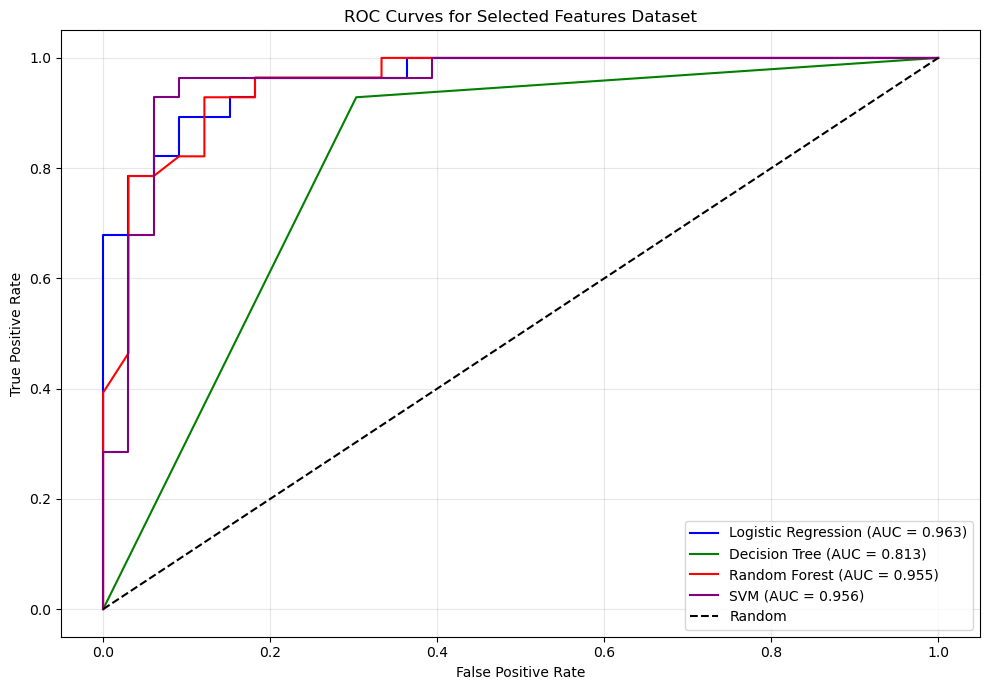


Results for Selected Features Dataset:
                     Accuracy  Precision    Recall        F1       AUC
Logistic Regression  0.868852   0.833333  0.892857  0.862069  0.963203
Decision Tree        0.803279   0.722222  0.928571  0.812500  0.812771
Random Forest        0.868852   0.812500  0.928571  0.866667  0.955087
SVM                  0.901639   0.843750  0.964286  0.900000  0.955628


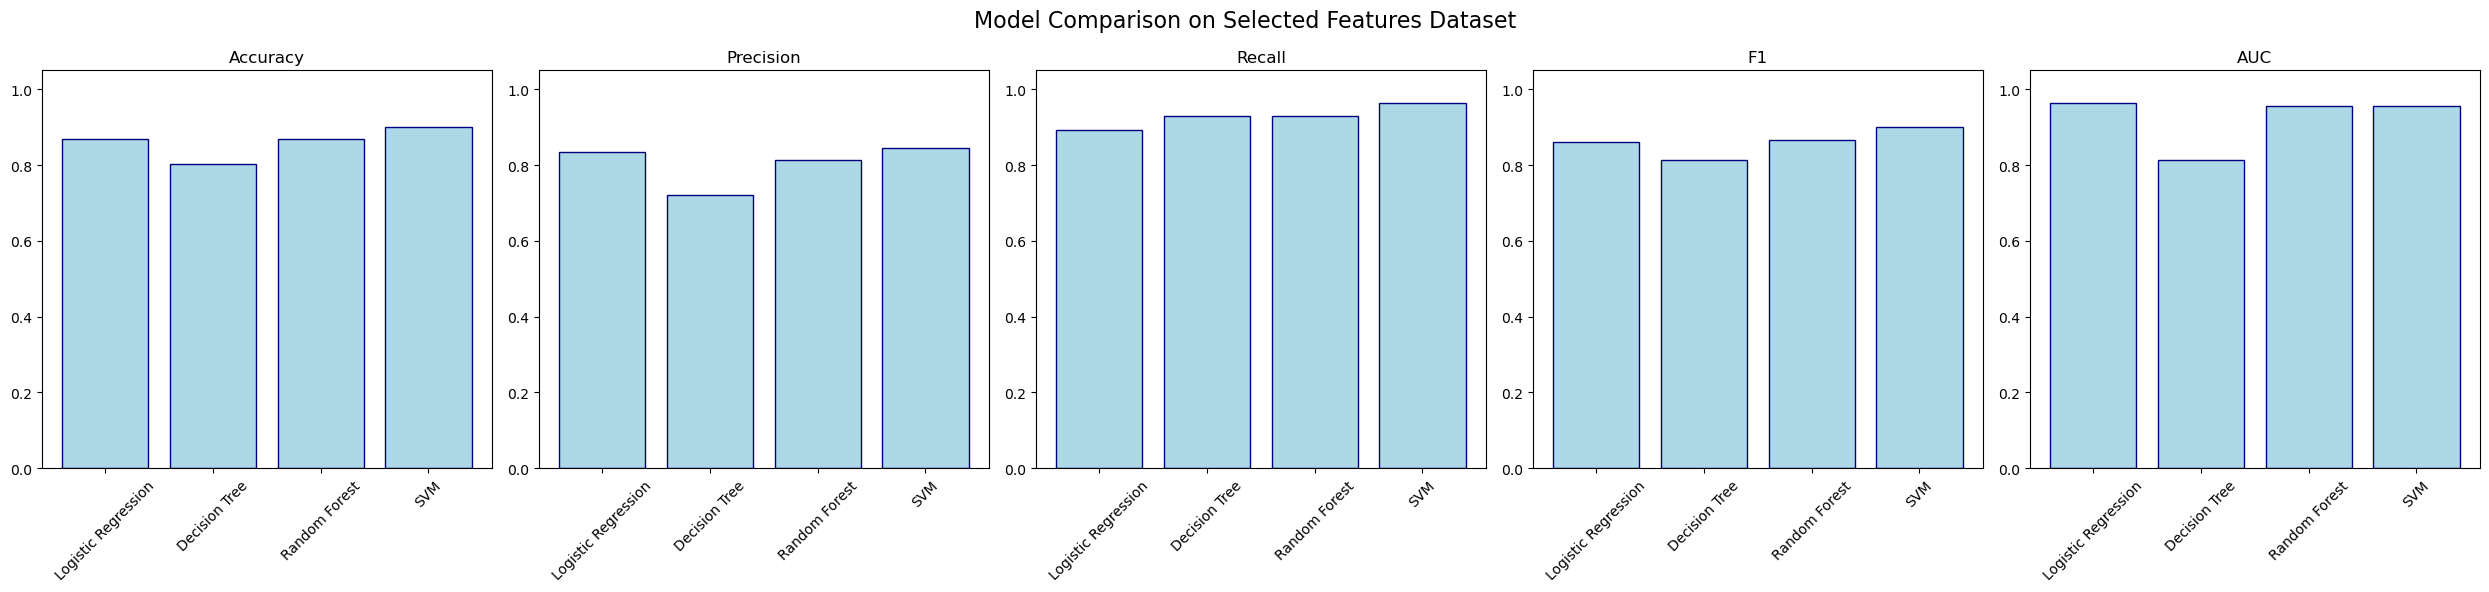


Best model for Selected Features Dataset is Logistic Regression with AUC 0.963

Detailed report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.83      0.89      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61


 Running on PCA Dataset
Training Logistic Regression
Training Decision Tree
Training Random Forest
Training SVM


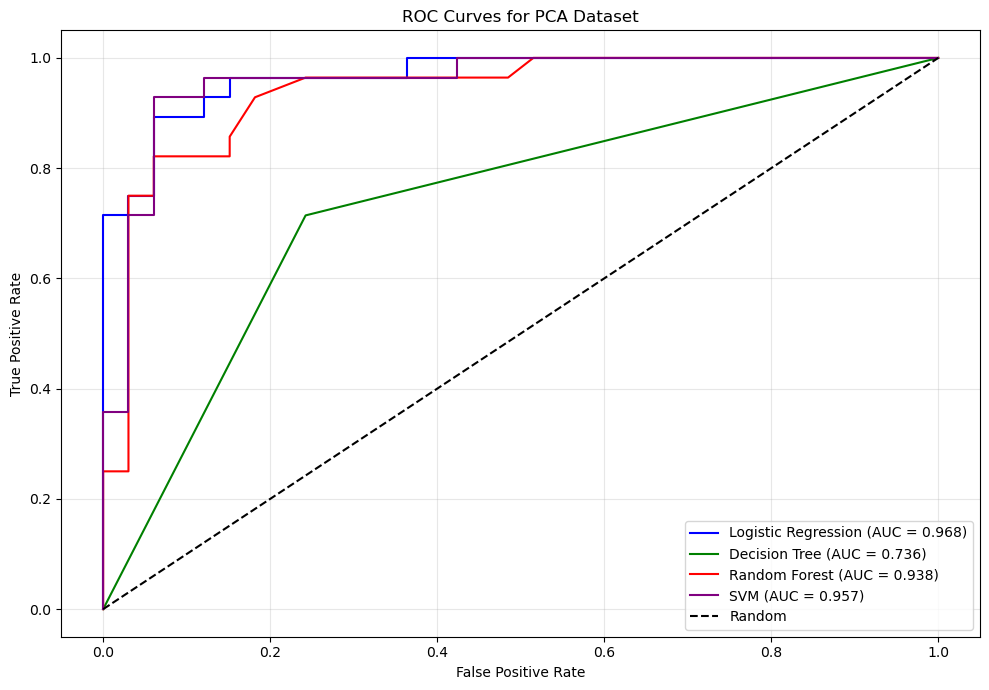


Results for PCA Dataset:
                     Accuracy  Precision    Recall        F1       AUC
Logistic Regression  0.901639   0.866667  0.928571  0.896552  0.967532
Decision Tree        0.737705   0.714286  0.714286  0.714286  0.735931
Random Forest        0.852459   0.827586  0.857143  0.842105  0.937771
SVM                  0.918033   0.870968  0.964286  0.915254  0.956710


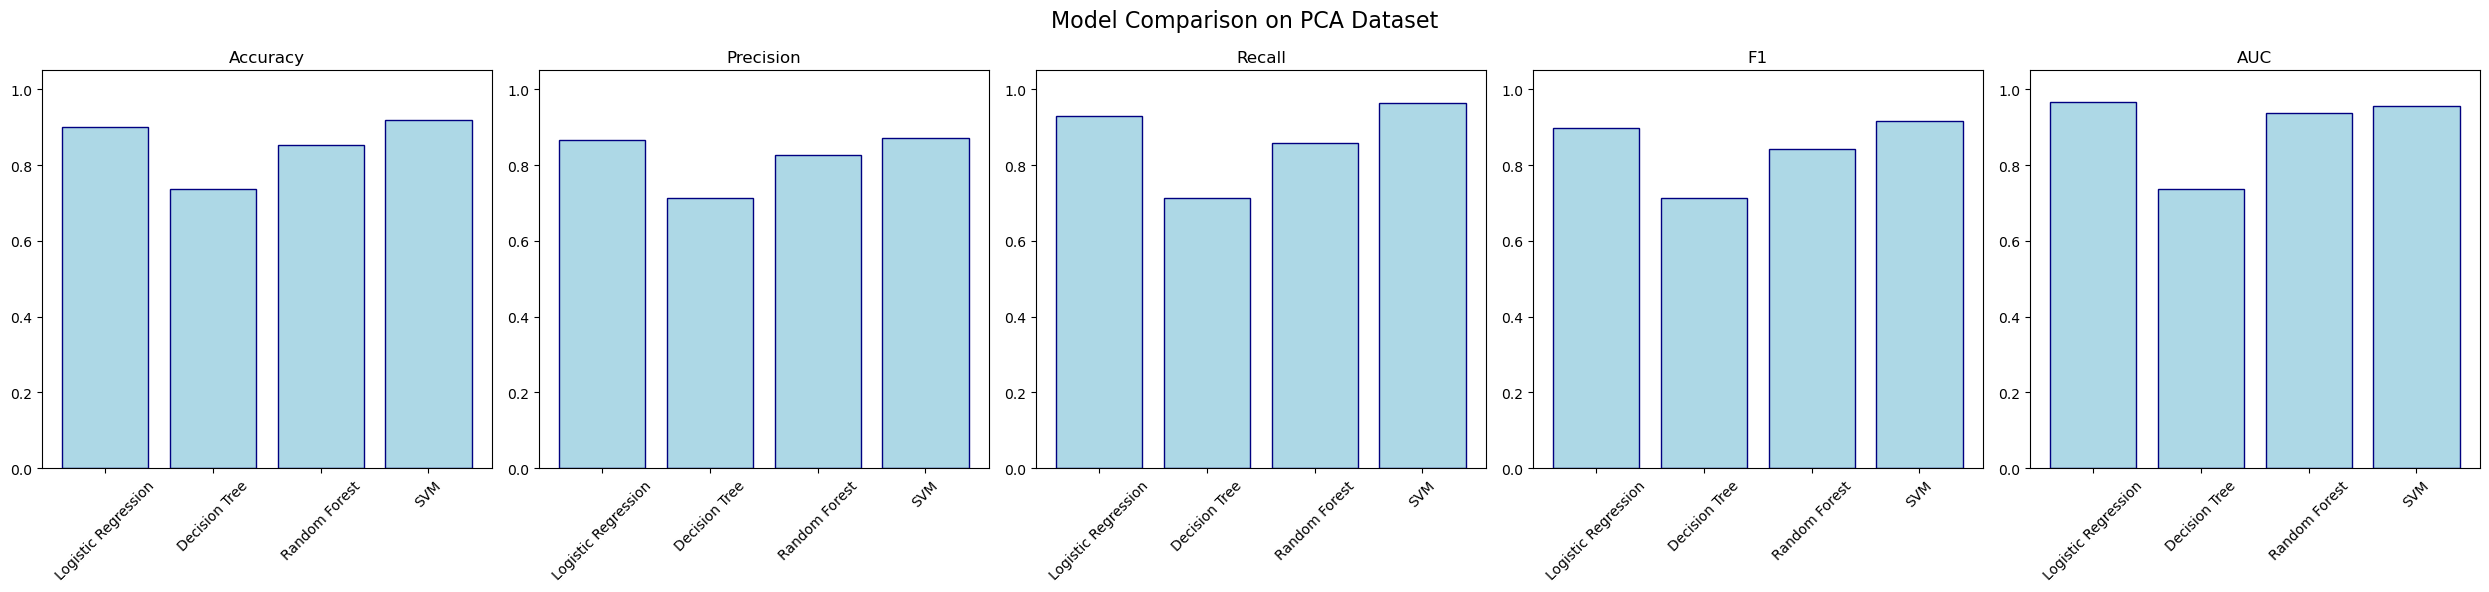


Best model for PCA Dataset is Logistic Regression with AUC 0.968

Detailed report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.87      0.93      0.90        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61


Best Accuracy - Selected Features: 0.902 (Model: SVM)
Best Accuracy - PCA: 0.918 (Model: SVM)
PCA improved best accuracy by 1.64%! 

Average Accuracy across models - Selected: 0.861
Average Accuracy across models - PCA: 0.852
PCA lowered average accuracy by 0.82%. Dimensionality reduction might have lost some info.

Best AUC - Selected Features: 0.963
Best AUC - PCA: 0.968
PCA improved best AUC by 0.43%.


In [9]:
print("\n Running on Selected Features ")
selected_results = do_the_models(selected_data, "Selected Features Dataset")

print("\n Running on PCA Dataset")
pca_results = do_the_models(pca_data, "PCA Dataset")

# Best accuracies
best_acc_selected = selected_results['Accuracy'].max()
best_acc_pca = pca_results['Accuracy'].max()
best_model_selected = selected_results[selected_results['Accuracy'] == best_acc_selected].index[0]
best_model_pca = pca_results[pca_results['Accuracy'] == best_acc_pca].index[0]

print(f"\nBest Accuracy - Selected Features: {best_acc_selected:.3f} (Model: {best_model_selected})")
print(f"Best Accuracy - PCA: {best_acc_pca:.3f} (Model: {best_model_pca})")

acc_improvement = (best_acc_pca - best_acc_selected) * 100
if acc_improvement > 0:
    print(f"PCA improved best accuracy by {acc_improvement:.2f}%! ")
else:
    print(f"PCA did not improve best accuracy (change: {acc_improvement:.2f}%). Might need tuning.")

# Average accuracy across all models
avg_acc_selected = selected_results['Accuracy'].mean()
avg_acc_pca = pca_results['Accuracy'].mean()
avg_improvement = (avg_acc_pca - avg_acc_selected) * 100

print(f"\nAverage Accuracy across models - Selected: {avg_acc_selected:.3f}")
print(f"Average Accuracy across models - PCA: {avg_acc_pca:.3f}")
if avg_improvement > 0:
    print(f"PCA improved average accuracy by {avg_improvement:.2f}% ")
else:
    print(f"PCA lowered average accuracy by {-avg_improvement:.2f}%")

# Also compare best AUCs 
best_auc_selected = selected_results['AUC'].max()
best_auc_pca = pca_results['AUC'].max()
auc_improvement = (best_auc_pca - best_auc_selected) * 100

print(f"\nBest AUC - Selected Features: {best_auc_selected:.3f}")
print(f"Best AUC - PCA: {best_auc_pca:.3f}")
if auc_improvement > 0:
    print(f"PCA improved best AUC by {auc_improvement:.2f}%.")
else:
    print(f"PCA did not improve best AUC (change: {auc_improvement:.2f}%).")

# Quick side-by-side table for all metrics (best models only, for simplicity)
comparison_df = pd.DataFrame({
    'Metric': ['Best Accuracy', 'Best AUC', 'Best Precision', 'Best Recall', 'Best F1'],
    'Selected Features': [
        selected_results['Accuracy'].max(),
        selected_results['AUC'].max(),
        selected_results['Precision'].max(),
        selected_results['Recall'].max(),
        selected_results['F1'].max()
    ],
    'PCA': [
        pca_results['Accuracy'].max(),
        pca_results['AUC'].max(),
        pca_results['Precision'].max(),
        pca_results['Recall'].max(),
        pca_results['F1'].max()
    ]
})


Side-by-Side Best Metrics Comparison:
           Metric  Selected Features    PCA
0   Best Accuracy              0.902  0.918
1        Best AUC              0.963  0.968
2  Best Precision              0.844  0.871
3     Best Recall              0.964  0.964
4         Best F1              0.900  0.915

Saved comparison table to 'comparison_selected_vs_pca.csv'


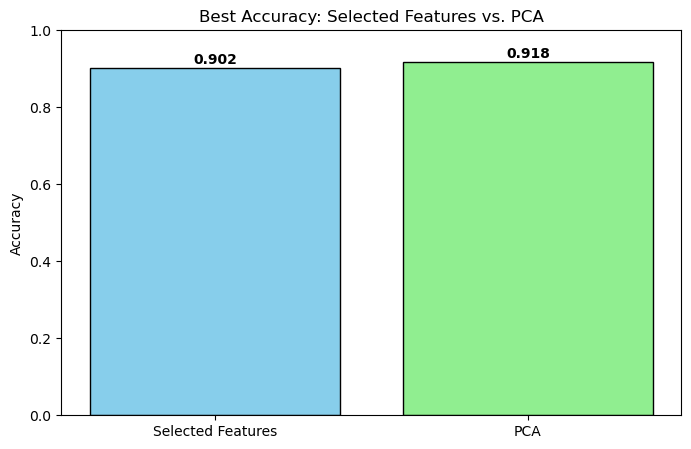

In [11]:
print("\nSide-by-Side Best Metrics Comparison:")
print(comparison_df.round(3))
# Save the comparison to CSV 
comparison_df.to_csv('comparison_selected_vs_pca.csv', index=False)
print("\nSaved comparison table to 'comparison_selected_vs_pca.csv'")
plt.figure(figsize=(8, 5))
datasets = ['Selected Features', 'PCA']
best_accs = [best_acc_selected, best_acc_pca]
plt.bar(datasets, best_accs, color=['skyblue', 'lightgreen'], edgecolor='black')
plt.title('Best Accuracy: Selected Features vs. PCA')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(best_accs):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.savefig('accuracy_comparison_selected_vs_pca.png', dpi=150)
plt.show()